In [1]:
!pip install emoji==0.6.0
!pip install transformers
!pip install soynlp
!pip install pytorch_lightning
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=932f9c9222e665fd909625dd996dec84819856cc905ec51ac633ef354ed1fa23
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 9.

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import sys
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from pytorch_lightning import LightningModule, Trainer, seed_everything
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize
import transformers
import emoji
import soynlp
import pytorch_lightning
from utils.emotion_model import Model
from utils.infer_emotion import infer
from utils.load_data import load_dataset, idx2emoticon, emoticon2idx, convert_sentence_emotion, add_emotion
from sentence_transformers import SentenceTransformer, util
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
# from Recommend import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def recommend(idx):
    cos_rank = {i : cos_sim_weighted[idx][i] for i in range(len(emoticon_sentence_with_emotion))}
    cos_rank = sorted(cos_rank.items(), key = lambda item: item[1], reverse = True)
    selected = {i : 0 for i, _ in idx2emoticon.items()}
    selected_sentence = {i : [] for i, _ in idx2emoticon.items()}

    rec_idx = []
    ref_emotion = []
    ref_sentence = []

    found = 0
    for i in range(len(emoticon_sentence_with_emotion)):
        emoticon = emoticon_labels[cos_rank[i][0]]
        # print(cos_rank[i][1])
        selected[emoticon] += 1
        selected_sentence[emoticon].append(cos_rank[i][0])
        if selected[emoticon] == find_threshold:
            found += 1
            rec_idx.append(emoticon)
            # print(idx2emoticon[emoticon])
            ref_emotion.append(emoticon_emotions[cos_rank[i][0]])
            # print(emoticon_emotions[cos_rank[i][0]])
            ref_sentence.append(selected_sentence[emoticon][0])
            ref_sentence.append(selected_sentence[emoticon][1])

        if found == recommend_num: break

    return rec_idx, ref_emotion, ref_sentence

In [5]:
emotion_model_path = '/content/drive/MyDrive/인공지능프로젝트/emotion_model.ckpt'
sentence_model_path = 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'
emoticon_sentence_path = '/content/sentence_emoticon.txt'
idx2emoticon_path = '/content/idx2emoticon.txt'
emoticon2idx_path = '/content/emoticon2idx.txt'

In [6]:
idx2emoticon = idx2emoticon(idx2emoticon_path)
emoticon2idx = emoticon2idx(emoticon2idx_path)

In [7]:
emotion_model = Model.load_from_checkpoint(emotion_model_path)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.weight', 'classifier.

In [8]:
sentence_model = SentenceTransformer(sentence_model_path)

In [9]:
find_threshold = 2
recommend_num = 5

In [10]:
record_hits = [] # 0, 0.5, 1, 1.5, 2
record_cos = [] 

In [11]:
grid_weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [34]:
for w in grid_weights:
    emotion_weight = w
    emoticon_weight_cos = w

    emoticon_sentence, emoticon_emotions, emoticon_labels = load_dataset(emoticon_sentence_path)
    emoticon_sentence_with_emotion = convert_sentence_emotion(sentence_model, emoticon_emotions, emoticon_weight_cos, emoticon_sentence)

    emoticon_sentence_without_emotion = sentence_model.encode(emoticon_sentence)

    # df_test = pd.read_csv('/content/cus_test.csv', sep=',')
    df_test = pd.read_csv('/content/cus_train.csv', sep=',')
    df_test = df_test[:5000]
    test_sentence = df_test['sentence']
    test_label = df_test['label']

    test_sentence_vector = [] # n X 768
    test_sentence_weighted = []                                 # n X 772
    for idx in range(len(test_sentence)):
        test_sentence_vector.append(sentence_model.encode(test_sentence[idx]))
        sv_emotion = infer(emotion_model, [test_sentence[idx]]).cpu().detach().numpy()
        test_sentence_weighted.append(add_emotion(sentence_model, emotion_weight, sv_emotion, test_sentence[idx]))

    cos_sim_weighted = cosine_similarity(test_sentence_weighted, emoticon_sentence_with_emotion)   # test_sentence X emoticon_dataset
    cos_sim_only_sentence = cosine_similarity(test_sentence_vector, emoticon_sentence_without_emotion)

    total_hits = 0
    total_cos_sim = 0

    for idx in range(len(test_sentence)):

        answer_emotion = test_label[idx]
        # print("Answer: ", test_sentence[idx], answer_emotion)
        rec_idx, ref_emotion, ref_sentence = recommend(idx)
        # print(ref_emotion)
        total_hits += np.sum(np.array(ref_emotion) == answer_emotion)
        total_cos_sim += np.sum(np.array(cos_sim_only_sentence[idx][ref_sentence]))
        # print(np.array(cos_sim_weighted[idx][ref_sentence]))
        # print(np.array(cos_sim_only_sentence[idx][ref_sentence]))

    hit_recommend_num = total_hits / (recommend_num * len(test_sentence))
    avg_cos_sim = total_cos_sim / (find_threshold * recommend_num * len(test_sentence))

    record_hits.append(hit_recommend_num)
    record_cos.append(avg_cos_sim)

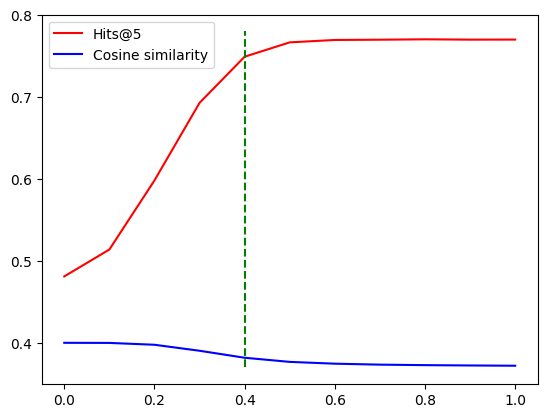

In [44]:
plt.plot(grid_weights, record_hits[11:], 'r', label='Hits@5')
plt.plot(grid_weights, record_cos[11:], 'b', label='Cosine similarity')
plt.vlines(x=0.4, ymin=0.37, ymax=0.78, color='green', linestyle='--')
plt.legend()
plt.show()

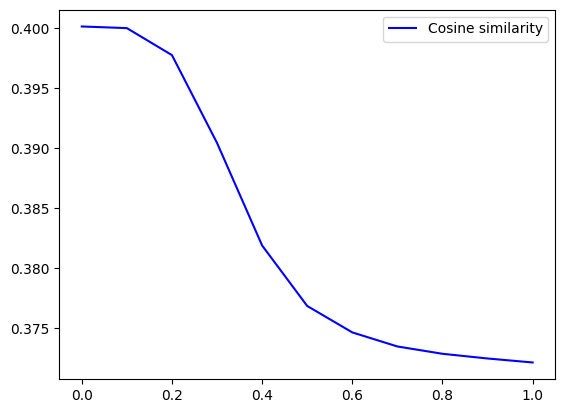

In [39]:
plt.plot(grid_weights, record_cos[11:], 'b', label='Cosine similarity')
plt.legend()
plt.show()

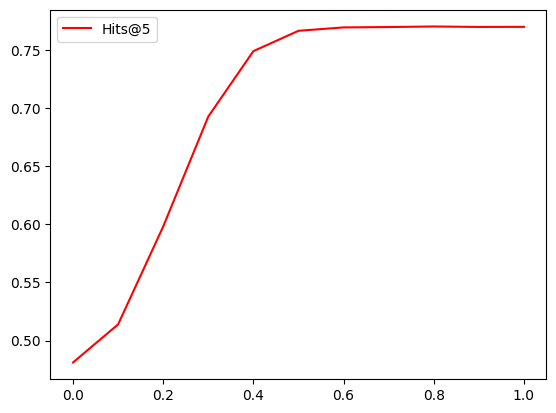

In [40]:
plt.plot(grid_weights, record_hits[11:], 'r', label='Hits@5')
plt.legend()
plt.show()

In [41]:
print('Record hits: ', record_hits[11:])
print('Record cos_sim: ', record_cos[11:])

Record hits:  [0.48112, 0.51392, 0.5982, 0.69288, 0.7492, 0.76672, 0.76964, 0.76996, 0.77044, 0.77004, 0.77012]
Record cos_sim:  [0.4001076512217522, 0.39997143861293794, 0.3977220623755455, 0.3904071119117737, 0.38186722153902053, 0.376829702539444, 0.3746289488887787, 0.3734577339220047, 0.372847630674839, 0.3724562654685974, 0.3721245655655861]


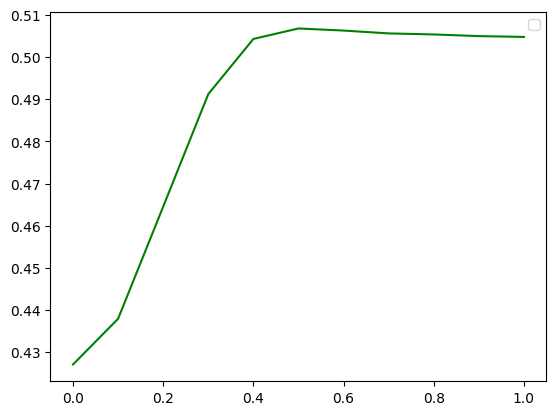

In [43]:
plt.plot(grid_weights, (2*np.array(record_cos[11:]) + np.array(record_hits[11:]))/3, 'g')
plt.legend()
plt.show()